# Рынок заведений общественного питания Москвы

Вы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами вы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможете ли вы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Вы — гуру аналитики, и партнёры просят вас подготовить исследование рынка. У вас есть открытые данные о заведениях общественного питания в Москве.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import requests
import re
from io import BytesIO

#загрузка данных и первичный осмотр 
data = pd.read_csv('/datasets/rest_data.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None


,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [2]:
#изменение типа данных 
data.loc[data['chain'] == 'да','chain'] = 1
data.loc[data['chain'] == 'нет','chain'] = 0
data['chain'] = data['chain'].astype('bool')

Необходимо поменять тип столбца data['chain'] c object на bool.  

In [3]:
#проверка наличия дубликатов и пропущенных значаний 
print(data.isna().sum())
data.duplicated().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64


0

In [4]:
data = data.drop_duplicates(subset=['object_name','chain','object_type','address','number'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
id             15284 non-null int64
object_name    15284 non-null object
chain          15284 non-null bool
object_type    15284 non-null object
address        15284 non-null object
number         15284 non-null int64
dtypes: bool(1), int64(2), object(3)
memory usage: 731.4+ KB


## Анализ данных

In [5]:
#соотношение видов объектов общественного питания
types = data.groupby('object_type').agg({'id':'count'}).reset_index()
types.columns = ['object_type','number']
types['percent'] = round(types['number']*100 / types['number'].sum(), 2)
types = types.sort_values(by='percent', ascending= False)
types

,object_type,number,percent
3,кафе,6071,39.72
8,столовая,2584,16.91
7,ресторан,2282,14.93
6,предприятие быстрого обслуживания,1898,12.42
0,бар,855,5.59
1,буфет,577,3.78
4,кафетерий,395,2.58
2,закусочная,349,2.28
5,магазин (отдел кулинарии),273,1.79


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

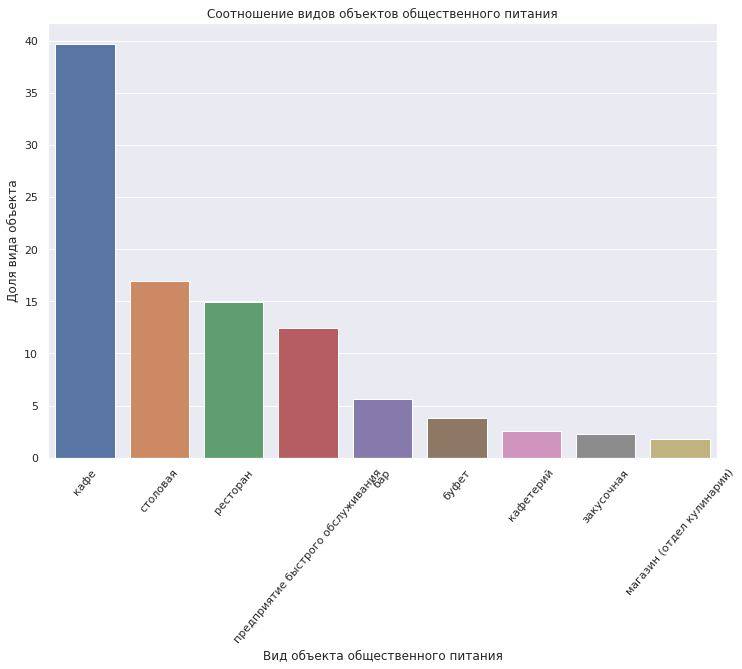

In [6]:
#график соотношения видов объектов общественного питания по количеству
sns.set(rc = {'figure.figsize':(12,8)})
g1 = sns.barplot(data=types, x='object_type', y='percent')
g1.set_title('Соотношение видов объектов общественного питания')
g1.set_ylabel('Доля вида объекта')
g1.set_xlabel('Вид объекта общественного питания')
plt.xticks(rotation = 50)

Среди объектов общественного питания преобладают кафе (39.7%) и столовые (16.8%), а самые не популярные это кулинарии в магазинах (1.8%) и закусочные (2.3%) 

In [7]:
# соотношение сетевых и несетевых заведений 
network = data.groupby('chain').agg({'id':'count'}).reset_index()
network.columns = ['chain','number']
network['percent'] = round(network['number']*100 / network['number'].sum(), 2)
network = network.sort_values(by='percent', ascending= False)
network

,chain,number,percent
0,False,12320,80.61
1,True,2964,19.39


Text(0.5, 0, 'Является ли объект сетевым?')

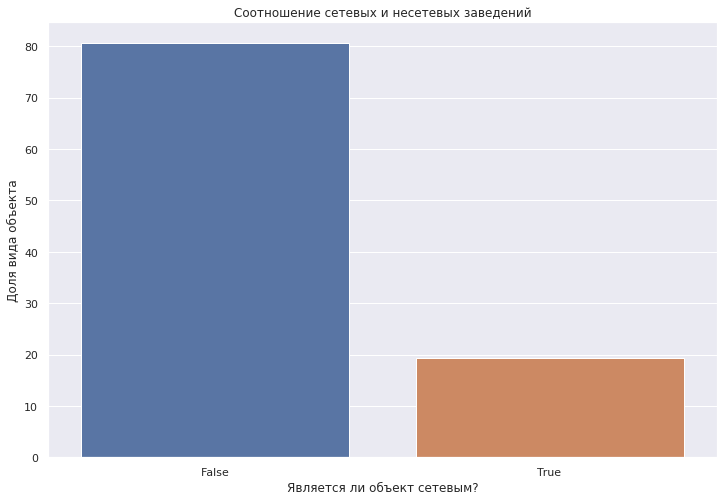

In [8]:
# грфик соотношения сетевых и несетевых заведений 
g2 = sns.barplot(data=network, x='chain', y='percent')
g2.set_title('Cоотношение сетевых и несетевых заведений')
g2.set_ylabel('Доля вида объекта')
g2.set_xlabel('Является ли объект сетевым?')

Толко около 20% объектов общественного питания являются сетевыми.

In [9]:
#Для какого вида объекта общественного питания характерно сетевое распространение
chain_type = data.pivot_table(index='object_type' , columns='chain', values='id',aggfunc='count') 
chain_type['chain_percent'] = round((chain_type[True]*100 / (chain_type[True]+chain_type[False])),2) 
chain_type = chain_type.reset_index(drop= False) 
chain_type = chain_type.sort_values(by= 'chain_percent', ascending= False)
chain_type

chain,object_type,False,True,chain_percent
6,предприятие быстрого обслуживания,1110,788,41.52
5,магазин (отдел кулинарии),195,78,28.57
7,ресторан,1739,543,23.79
3,кафе,4675,1396,22.99
2,закусочная,293,56,16.05
4,кафетерий,343,52,13.16
0,бар,818,37,4.33
1,буфет,566,11,1.91
8,столовая,2581,3,0.12


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

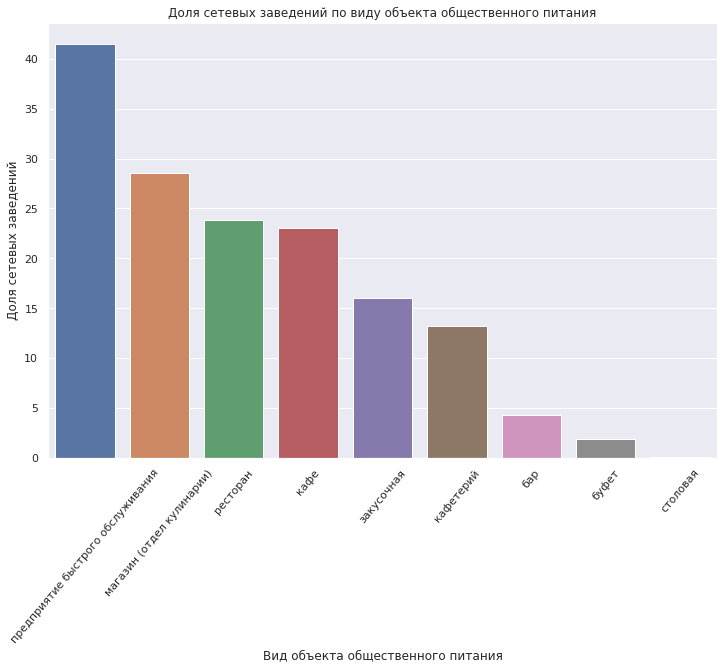

In [10]:
#График доли сетевых заведений среди рахных видов объектов общественного питания
g3 = sns.barplot(data=chain_type, x='object_type' , y='chain_percent')
g3.set_title('Доля сетевых заведений по виду объекта общественного питания')
g3.set_ylabel('Доля сетевых заведений')
g3.set_xlabel('Вид объекта общественного питания')
plt.xticks(rotation = 50)

Сетевые объекты больше популярные среди прдприятий быстрого обслуживания, магазинов, ресторанов и кафе. В то время как сетевые не популярные среди столовых, буфетов и баров. 

In [11]:
#Характеристики сетевых заведений
network2 = data[data['chain'] == True].groupby('object_name').agg({'id':'count', 'number':'mean'}).reset_index()
network2.describe()

,id,number
count,724.000000,724.000000
mean,4.093923,60.322928
std,12.601654,56.132975
min,1.000000,0.000000
25%,1.000000,20.000000
50%,1.000000,45.000000
75%,2.000000,83.625000
max,155.000000,356.000000


Большинство сетей имеет 1 или 2 заведения. В средним около 60 посадочных мест в каждом заведений. Это означает что Для сетевых заведений характерно мало заведений с средним или большим числом посадочных мест. 

In [12]:
#рассчет среднего количества посадочных мест по виду объекта
types2 = data.groupby('object_type').agg({'number':'mean'}).reset_index()
types2.columns = ['object_type','number_mean']
types2['number_mean'] = round(types2['number_mean'])
types2 = types2.sort_values(by='number_mean', ascending= False)
types2

,object_type,number_mean
8,столовая,130.0
7,ресторан,97.0
1,буфет,52.0
0,бар,44.0
3,кафе,40.0
6,предприятие быстрого обслуживания,21.0
4,кафетерий,9.0
2,закусочная,8.0
5,магазин (отдел кулинарии),6.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

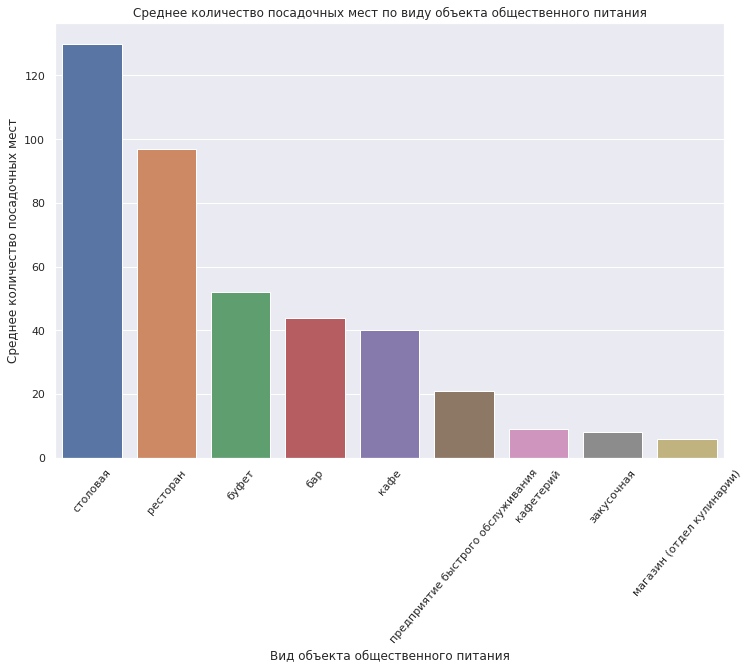

In [13]:
#график среднего количества посадочных мест по виду объекта
g4 = sns.barplot(data=types2, x='object_type', y='number_mean')
g4.set_title('Cреднее количество посадочных мест по виду объекта общественного питания')
g4.set_ylabel('Cреднее количество посадочных мест')
g4.set_xlabel('Вид объекта общественного питания')
plt.xticks(rotation = 50)

Столовые и рестораны имеют наибольшие посадочные места, 130 и 97, соответственно. А кулинарии и закусочные имеют наименьшие количества посадочных мест. 

In [14]:
# выделение названий улиц
words = ['улица','ул','переулок','шоссе','проспект','площадь','проезд','село','аллея','бульвар','набережная','тупик','линия']
str_pat = r".*,\s*\b([^,]*?(?:{})\b[^,]*)[,$]+".format("|".join(words))
data['streetname'] = data['address'].str.extract(str_pat, flags=re.I)

In [15]:
# Определение топ-улиц по количеству заведений
top_streets = data.groupby('streetname').agg({'id':'count'}).reset_index()
top_streets.columns = ['street','rest_number']
top_streets2 = top_streets.sort_values(by= 'rest_number', ascending= False).head(10)
top_streets2

,street,rest_number
1418,проспект Мира,204
1009,Профсоюзная улица,181
683,Ленинградский проспект,170
993,Пресненская набережная,167
397,Варшавское шоссе,164
686,Ленинский проспект,147
1414,проспект Вернадского,128
673,Кутузовский проспект,114
596,Каширское шоссе,111
603,Кировоградская улица,108


In [16]:
# Список названий топ-10 улиц
ten_street_names = []
for i in top_streets2['street']:
    resultwords  = [word for word in re.split("\W+",i) if word.lower() not in words]
    ten_street_names.append(' '.join(resultwords))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

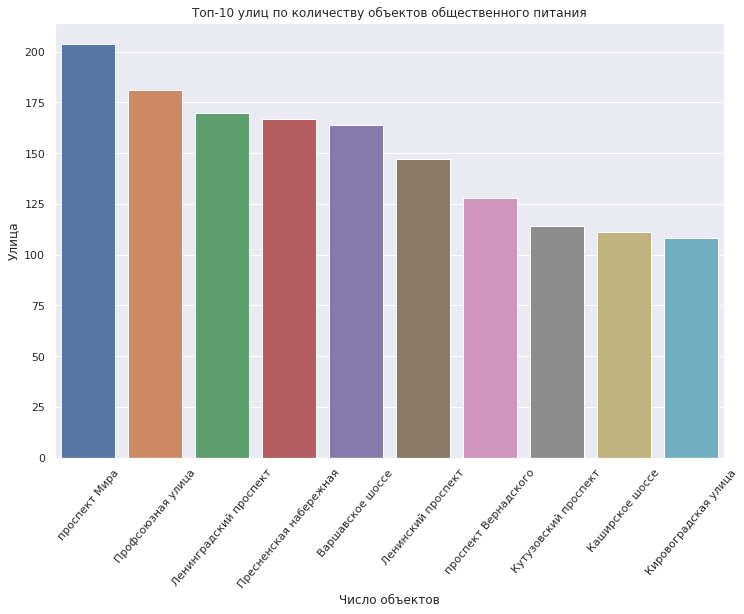

In [17]:
# график топ-10 улиц
g5 = sns.barplot(data=top_streets2, x='street', y='rest_number')
g5.set_title('Топ-10 улиц по количеству объектов общественного питания')
g5.set_ylabel('Улица')
g5.set_xlabel('Число объектов')
plt.xticks(rotation = 50)

In [18]:
#импорт датасета с названиями районов Москвы
spreadsheet_id = "1pY2pz9mSDGn3OO_b2JuOECU5ABopxJE4-UiaRaF-xrQ"
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.head()

,area_id,full_address,city,address,street_prefix,street_name,building,house_id,area_name,house_year
0,2281084,г Москва п Загорье д.10,Москва,п Загорье д.10,п,Загорье,д.10,7569627,муниципальный округ Бирюлево Восточное,1968
1,2281084,г Москва п Загорье д.3,Москва,п Загорье д.3,п,Загорье,д.3,7569823,муниципальный округ Бирюлево Восточное,1964
2,2281084,г Москва п Загорье д.4,Москва,п Загорье д.4,п,Загорье,д.4,7569840,муниципальный округ Бирюлево Восточное,1972
3,2281084,г Москва п Загорье д.5,Москва,п Загорье д.5,п,Загорье,д.5,7569862,муниципальный округ Бирюлево Восточное,1963
4,2281084,г Москва п Загорье д.8,Москва,п Загорье д.8,п,Загорье,д.8,7569888,муниципальный округ Бирюлево Восточное,1963


In [19]:
#выделений названий улиц  с соответсующими районами 
moscow_areas = df[['street_name','area_name']].drop_duplicates().reset_index(drop=True)
moscow_areas.head()

,street_name,area_name
0,Загорье,муниципальный округ Бирюлево Восточное
1,Загорьевский,муниципальный округ Бирюлево Восточное
2,Михневский,муниципальный округ Бирюлево Восточное
3,Бирюлевская,муниципальный округ Бирюлево Восточное
4,Донбасская,муниципальный округ Бирюлево Восточное


In [20]:
#Определение районов, где находятся топ-10 улиц 
areas1 = moscow_areas[moscow_areas.loc[:,'street_name'].isin(ten_street_names)].reset_index(drop = True)
areas1

,street_name,area_name
0,Ленинский,муниципальный округ Донской
1,Варшавское,муниципальный округ Донской
2,Каширское,муниципальный округ Москворечье-Сабурово
3,Варшавское,муниципальный округ Нагатино-Садовники
4,Каширское,муниципальный округ Нагатино-Садовники
5,Варшавское,муниципальный округ Нагорный
6,Каширское,муниципальный округ Орехово-Борисово Северное
7,Каширское,муниципальный округ Орехово-Борисово Южное
8,Ленинградский,муниципальный округ Чертаново Северное
9,Кировоградская,муниципальный округ Чертаново Северное


In [21]:
# число улиц с одним объектом общественного питания
print(len(top_streets[top_streets['rest_number'] == 1]))

551


In [22]:
#Датафрейм с названиями улиц с одним заведением 
one_rest = top_streets[top_streets['rest_number'] == 1]
one_rest.head()

,street,rest_number
2,1-й Балтийский переулок,1
3,1-й Басманный переулок,1
4,1-й Ботанический проезд,1
7,1-й Вешняковский проезд,1
9,1-й Голутвинский переулок,1


In [23]:
#Определение районов, в котором находятся улицы с одним заведением 
onerest_street_names = []
for i in one_rest['street']:
    resultwords  = [word for word in re.split("\W+",i) if word.lower() not in words]
    onerest_street_names.append(' '.join(resultwords))

In [24]:
areas2 = moscow_areas[moscow_areas.loc[:,'street_name'].isin(onerest_street_names)].reset_index(drop = True)
print(len(areas2['area_name'].unique()))

84


Улицы с одним заведением общественного питания находятся в 51 районах Москвы, которые были определены выше. 

count    1494.000000
mean       58.180054
std        90.165467
min         0.000000
25%        12.000000
50%        40.000000
75%        75.000000
max      1700.000000
Name: number, dtype: float64

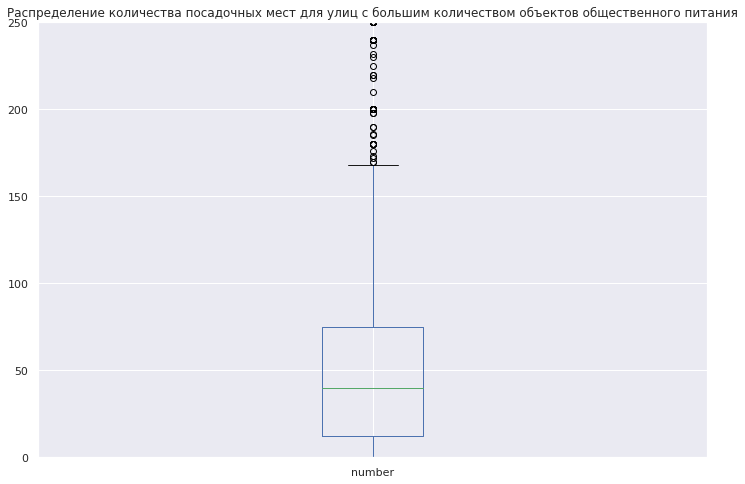

In [25]:
#распределение количества посадочных мест для улиц с большим количеством объектов общественного питания
distribution = data[data['streetname'].isin(top_streets2['street'])]
g1 = distribution['number'].plot(kind='box')
g1.set_ylim(0,250)
g1.set_title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания')
distribution['number'].describe()

75% заведений, находящихся на улицах с большим количеством ООП имеют меньше 63 посадочных мест. 

Выводы: 

- Кафе является самым популярным видом ООП.
-  Большинство ООП является не сетевым. 
- Сетевые заведения характерны для предприятий быстрого обслуживания и кулинарий магазинов. 
- Сетевым заведениям характерно мало заведений с средним - большим количеством посадочных мест. 
- Столовые и рестораны имеют наибольшее количество посадочных мест. 
- Абсолютное большинство заведений улиц с большим количеством ООП имеет меньше 100 посадочных мест.

Презентация: https://disk.yandex.ru/i/gse_OkxV4EaQXg

Рекомендации: 

- Открыть одно заведение (не сетевое кафе).
- Рекомендуемое число посадочных мест -  (70-80).  
- Открыть кафе на одном из улиц с большим количеством кафе и большим средним чеком в них.
